# Project Maskify

Hello!

In this project, you will learn how to create a simple Python program to put a mask on your face. Like this:

<img src="results/sample.jpg" width="40%"/>


The main idea is to use **[Face API](https://docs.microsoft.com/azure/cognitive-services/face/overview/?WT.mc_id=studconf-8892-dmitryso)**, which allows us to extract coordinates of key points of the face - so called **Facial Landmarks**. We will then use image manipulation machinery to overlay the image on top of the face.

### Some pre-requisites

First of all, we need to make sure that the libraries that we need are installed in our Python distribution. We would use `Pillow` to do image manipulations, and `matplotlib` to show our results.

In [9]:
import sys
!{sys.executable} -m pip install --user --quiet matplotlib pillow
import PIL
import matplotlib.pyplot as plt
import glob, os
import numpy as np

### Extracting Facial Landmarks

To extract facial landmarks, we will use [Microsoft Face API](https://azure.microsoft.com/services/cognitive-services/face/?WT.mc_id=studconf-8892-dmitryso). It provides a simple REST API that can extract a lot of useful information from the face image, including those landmarks:

![Facial Landmarks](https://raw.githubusercontent.com/shwars/FaceArt/master/notebooks/img/landmarks.jpg)

It is quite easy to call Face API directly via REST, but it is even better to use existing SDK, which is available for Python as part of [Azure SDK library](https://docs.microsoft.com/ru-ru/azure/cognitive-services/face/quickstarts/python-sdk/?WT.mc_id=studconf-8892-dmitryso).

You can [visit Microsoft Docs](https://docs.microsoft.com/ru-ru/azure/cognitive-services/face/index/?WT.mc_id=studconf-8892-dmitryso) for more detailed information on Face API and using it from languages other than Python.

In [2]:
!{sys.executable} -m pip install --quiet --user azure-cognitiveservices-vision-face

To use Face API, we need to provide a key and endpoint URL (because it is available in different regions, URL can be different). There are many ways to obtain Face API Key:

* If you have an Azure Subscription, the best option is to [create Cognitive Services resource](https://docs.microsoft.com/en-us/azure/cognitive-services/cognitive-services-apis-create-account/?WT.mc_id=studconf-8892-dmitryso), and grab key/url from there
* You can always [create free trial subscription](https://azure.microsoft.com/free/?WT.mc_id=studconf-8892-dmitryso) (you would need a credit card for that)
* If you do not have an Azure Subscription, you can try Face API for free - request your trial key [here](https://azure.microsoft.com/try/cognitive-services/my-apis/?api=face-api&WT.mc_id=studconf-8892-dmitryso).

**Important:** If you use trial key, your Face API will have some limitations, in terms of number of images you can process, and frequency of API calls (not more than 20 calls per minute). In case you decide to process a bunch of images to put the mask on, you will need to take this into account.

After you get the key and endpoint, please insert them into the cell below. There would typically be two keys given on the portal, you can use any one of them.

In [3]:
key = '--INSERT YOUR KEY HERE--'
endpoint = 'https://westus2.api.cognitive.microsoft.com' 
# You might need different endpoint, check the cognitive services page!


Most of the calls of the Face API are done through the static module `cognitive_face`, which we will call `cf` for brevity.

In [4]:
import azure.cognitiveservices.vision.face as cf
from msrest.authentication import CognitiveServicesCredentials
cli = cf.FaceClient(endpoint,CognitiveServicesCredentials(key))

The main function for face detection is called `face.detect_with_url` or `face.detect_with_stream`. It can extract a lot of useful information from the face, depending on the parameters that you specify - in our case we would need facial landmarks:

In [5]:
face_url = 'https://2016.dotnext-piter.ru/assets/images/people/soshnikov.jpg'
res = cli.face.detect_with_url(face_url,return_face_landmarks=True)
print(res[0].face_landmarks.as_dict())

{'pupil_left': {'x': 112.6, 'y': 126.7}, 'pupil_right': {'x': 170.9, 'y': 118.9}, 'nose_tip': {'x': 148.7, 'y': 158.4}, 'mouth_left': {'x': 121.6, 'y': 182.6}, 'mouth_right': {'x': 177.8, 'y': 172.1}, 'eyebrow_left_outer': {'x': 84.1, 'y': 120.3}, 'eyebrow_left_inner': {'x': 122.9, 'y': 110.1}, 'eye_left_outer': {'x': 103.3, 'y': 128.9}, 'eye_left_top': {'x': 112.3, 'y': 122.8}, 'eye_left_bottom': {'x': 113.7, 'y': 131.4}, 'eye_left_inner': {'x': 122.4, 'y': 126.7}, 'eyebrow_right_inner': {'x': 157.2, 'y': 106.3}, 'eyebrow_right_outer': {'x': 192.1, 'y': 106.6}, 'eye_right_inner': {'x': 162.7, 'y': 120.8}, 'eye_right_top': {'x': 171.3, 'y': 115.0}, 'eye_right_bottom': {'x': 172.7, 'y': 123.5}, 'eye_right_outer': {'x': 181.5, 'y': 118.5}, 'nose_root_left': {'x': 135.4, 'y': 126.3}, 'nose_root_right': {'x': 151.5, 'y': 124.3}, 'nose_left_alar_top': {'x': 131.9, 'y': 147.4}, 'nose_right_alar_top': {'x': 158.4, 'y': 143.8}, 'nose_left_alar_out_tip': {'x': 128.2, 'y': 159.3}, 'nose_right_al

## Loading an Image

This repository contains some sample image to play with. Feel free to use your own image -- provide the correct name in the cell below:

In [7]:
path = 'images/sample.jpg'

Let's see how facial landmarks extraction works in practice by plotting points over a face:

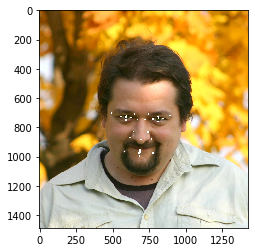

In [42]:
img = np.array(PIL.Image.open(path))
with open(path,'rb') as f:
    res = cli.face.detect_with_stream(f,return_face_landmarks=True)
for k,v in res[0].face_landmarks.as_dict().items():
    x,y = int(v['x']),int(v['y'])
    img[y-5:y+5,x-5:x+5,:] = 255
plt.imshow(img)

Let's also load the mask image:

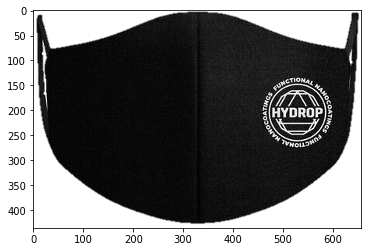

In [21]:
mask = PIL.Image.open("images/mask.png")
plt.imshow(mask)

## Maskifying the face

Now let's come to the actual code to add mask to the image. 

First of all, we need to define a function to properly resize the image to the given width, in order to resize our mask. The code is borrowed from [here](https://stackoverflow.com/questions/273946/how-do-i-resize-an-image-using-pil-and-maintain-its-aspect-ratio):

In [27]:
def resize(img, basewidth):
    wpercent = (basewidth/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    return img.resize((basewidth,hsize), PIL.Image.ANTIALIAS)

To place the mask over the image, we need to do the following:
* Decide which facial landmarks to use to place the image of the mask over the face. We will use coordinates of `NoseTip` and `EyeLeftBottom` to align the upper part of the mask somewhere between the nose and eye level.
* Resize the mask to the appropriate size. We will use `EyeBrowLeftOuter` and `EyeBrowRightOuter` x-coordinates to compute width of the mask
* Overlaying images is described [here](https://stackoverflow.com/questions/5324647/how-to-merge-a-transparent-png-image-with-another-image-using-pil) 

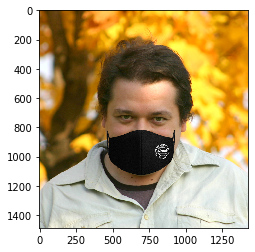

In [40]:
def maskify(path):
    img = PIL.Image.open(path)
    with open(path,'rb') as f:
        res = cli.face.detect_with_stream(f,return_face_landmarks=True)
    if len(res)<1:
        return img
    fc = res[0].face_landmarks.as_dict()
    width = fc['eyebrow_right_outer']['x']-fc['eyebrow_left_outer']['x']
    width = int(1.2*width)
    m = resize(mask,width)
    px = (fc['eyebrow_right_outer']['x']+fc['eyebrow_left_outer']['x'])/2 - width/2
    img.paste(m, (int(px), int((fc['nose_tip']['y']+fc['eye_left_bottom']['y'])/2)), m)
    return img 

im = maskify(path)
plt.imshow(im)

## Saving the result

You can use standard PIL function to save the resulting image:

In [41]:
im.save('results/sample.jpg')